# NLP (Natural Language Processing) Capstone Project

<img src='http://www.expertsystem.com/wp-content/uploads/2016/07/Natural-Language-Processing-Definition-1.jpg' />
___

# The challenge

* The [`domain classification`](https://github.com/hellohaptik/haptik_open_datasets/tree/master/domain_classification) challenge from [Haptik Open Datasets](https://github.com/hellohaptik/haptik_open_datasets): Classify (short) user queries into one of the given nine classes.

### The Nine classes/Domains are:

 1. **Food**
 2. **Recharge and Bills**
 3. **Support**
 4. **Reminders**
 5. **Travel**
 6. **Nearby**
 7. **Movies**
 8. **Casual**
 9. **Other**

Expected Performance
Suggested metric: Overall Accuracy/Subset Accuracy

Expected Performance: >70%

Subset Accuracy is not appropriate for this task, so we'll use label accuracy for model development.
For example, Subset Accuracy cannot distinguish between a model that gets 1 out of 3 positive labels wrong and a model that gets 2 out of 3 positive labels wrong (for a given document).

## Importing necessary modules and utility functions

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from pprint import pprint
from autocorrect import spell
import string
import copy
import time

import pandas as pd
import numpy as np

from nltk.tokenize import TreebankWordTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from collections import OrderedDict
import copy
import string
import operator

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import collections, itertools

In [2]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

## Approach :
----------

## Steps:

  1. **Reading the data file.**
  2. **Splitting the data into feature and target variables.**
  3. **Converting the target variables into the right format for training.**
  4. **Preprocessing.**
        - Converting string into Lowercase
        - Perform Tokenization process
        - Stopwords removal
        - Remove punctuations
        - Perform Stemming, it is a common technique to reduce topically similar words to their root.
        
  5. ** Creating a WordCloud from our original dataset**
        - Then lookout for unneccesary words that dont have much predictory power.
        - Create a total custom curated words that can be removed during preprocessing and then perform the classification task.
  6. ** Define a function label_accuracy to calculate the Label accuracy.**
  7. ** Classification Task.**
  8. ** Trying to classify with other models.**  
-----------

In [46]:
# Step 1: Reading the data 

def read_data(file_location):
    try:
        df = pd.read_csv(file_location, encoding = 'UTF-8')
        """
        Returns a dataframe after reading the csv file
        """
        return df
    except:
        raise IOError('FileNotFound')

In [47]:
# Step 2: Separating the feature and target variables

def xy_separator(df):
    """
    Separates feature matrix (column 0) and target vector (the rest)
    """
    X = pd.Series(df.iloc[:, 0])
    y = df.iloc[:, 1:].astype(str).replace({'T':1,'F':0})
    return X, y

In [48]:
# Step 3: Representation

def representation(X_train, y_train, X_test, y_test):
    
    rep = print("\nX_train_shape: {} \ny_train_shape: {} \nX_test_shape: {} \ny_test_shape: {}".format(X_train.shape,\
                                                                                                       y_train.shape,\
                                                                                                       X_test.shape,\
                                                                                                       y_test.shape))
    return rep

In [49]:
# Step 4: Preprocessing

def preprocess(list_of_X, custom_stop = [], stem = False):
    """
    Applies pre-processing pipelines to lists of string
    """
    en_stop = get_stop_words('en')
    en_stop.extend(custom_stop)
    tokenizer = TreebankWordTokenizer()
    p_stemmer = PorterStemmer()
    
    list_of_X = list_of_X.apply(lambda row: row.lower())
    list_of_X = list_of_X.apply(lambda row: tokenizer.tokenize(row))
    list_of_X = list_of_X.apply(lambda row: [i for i in row if i not in en_stop])
    list_of_X = list_of_X.apply(lambda row: [i for i in row if i not in string.punctuation])
    
    if stem == True:
        list_of_X = list_of_X.apply(lambda row: [p_stemmer.stem(i) for i in row])
    return list_of_X

In [50]:
# Step 5: EDA
@timeit
def create_word_cloud(X):
    """
    Create a word cloud
    """
    X1 = copy.deepcopy(X)
    if (any(isinstance(row, unicode) for row in X1)):
        X1 = X1.apply(lambda row: row.split(' '))
    plt.figure(figsize=(8,4));
    text = []
    for sentence in X1:
        text.extend(sentence)
    textall = " ".join(text)
    wordcloud = WordCloud(max_font_size=30).generate(textall)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [51]:
# Step 6: Defining a function to calculate the label accuracy

def label_accuracy(y_true, y_pred):
    """
    Compute label accuracy
    """
    res = (y_true == y_pred)
    return (res).sum().sum()/res.size

In [52]:
# Step 7: Classification 
@timeit
def classify(X_train,y_train,X_test,y_test,model= OneVsRestClassifier(ExtraTreesClassifier()),
             vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)):
    """
    Fit a model to the dataset
    """
    vect = vectorizer
    X_train = pd.Series([' '.join(x) for x in X_train])
    X_test = pd.Series([' '.join(x) for x in X_test])
    y_train = copy.deepcopy(y_train)
    y_test = copy.deepcopy(y_test)
        
    # Vectorize
    vect.fit(X_train)
    train_dtm = vect.transform(X_train)
    test_dtm = vect.transform(X_test)
    
#     from sklearn.naive_bayes import MultinomialNB
#     from sklearn.grid_search import GridSearchCV
    
#     param_grid1 = {"estimator__alpha": np.arange(0, 1, 0.01),
#                   "estimator__fit_prior": [True, False]}
    
#     model_tunning = GridSearchCV(model, param_grid=param_grid1)
#     model_tunning.fit(train_dtm, y_train)

#     print (model_tunning.best_score_)
#     print (model_tunning.best_params_)
    
    # Fit and predict
    model.fit(train_dtm, y_train)        
    y_pred_class = model.predict(test_dtm)
    
    # Find accuracy metrics
    accuracy_subset = metrics.accuracy_score(y_test, y_pred_class)
    accuracy_label = label_accuracy(y_test, y_pred_class)
    c_report = metrics.classification_report(y_test, y_pred_class)
    print('accuracy_label: ', accuracy_label)
    print('accuracy_subset: ', accuracy_subset)
    print('\n')
    print('classification report: \n', c_report)
    return None

### Splitting the dataset into train and test

In [53]:
train = read_data('data/train_data.csv')
test  = read_data('data/test_data.csv')

In [54]:
train.head(10)   ## Row 7 has multi class/label

,message,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,7am everyday,F,F,F,T,F,F,F,F,F
1,chocolate cake,T,F,F,F,F,F,F,F,F
2,closed mortice and tenon joint door dimentions,F,F,T,F,F,F,F,F,F
3,train eppo kelambum,F,F,F,F,T,F,F,F,F
4,yesterday i have cancelled the flight ticket,F,F,F,F,T,F,F,F,F
5,chamge it to 12pm to 9pm,F,F,F,F,T,F,F,F,F
6,i want too going rajasthan,F,F,F,F,T,F,F,F,F
7,room,F,F,F,F,T,F,T,F,F
8,can you please arrange flight tickets?,F,F,F,F,T,F,F,F,F
9,what kind of reminder,F,F,F,T,F,F,F,F,F


In [55]:
test.head()

,message,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,Nearest metro station,F,F,F,F,F,T,F,F,F
1,Pick up n drop service trough cab,F,F,F,F,T,F,F,F,F
2,I wants to buy a bick,F,F,F,F,F,F,F,F,T
3,Show me pizza,T,F,F,F,F,F,F,F,F
4,What is the cheapest package to andaman and ni...,F,F,F,F,T,F,F,F,F


### Splitting into Features and Target variables
* And also converting Target variables into the right format ie from ('T','F') -> (1,0)

In [56]:
X_train, y_train = xy_separator(train)
X_test, y_test = xy_separator(test)

In [57]:
X_train.head()

0                                      7am everyday
1                                    chocolate cake
2    closed mortice and tenon joint door dimentions
3                               train eppo kelambum
4      yesterday i have cancelled the flight ticket
Name: message, dtype: object

In [58]:
X_test.head()

0                                Nearest metro station
1                    Pick up n drop service trough cab
2                                I wants to buy a bick
3                                        Show me pizza
4    What is the cheapest package to andaman and ni...
Name: message, dtype: object

In [59]:
type(X_train)

pandas.core.series.Series

In [60]:
y_train.head()    # true,false -> 1,0

,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [61]:
y_test.head()

,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [62]:
representation(X_train, y_train, X_test, y_test)


X_train_shape: (40659,) 
y_train_shape: (40659, 9) 
X_test_shape: (10000,) 
y_test_shape: (10000, 9)


## EDA

In [63]:
X_train_1 = preprocess(X_train, stem = True)
X_test_1 = preprocess(X_test, stem = True)

In [64]:
X_train_1.head()

0                                [7am, everyday]
1                                 [chocol, cake]
2    [close, mortic, tenon, joint, door, diment]
3                        [train, eppo, kelambum]
4            [yesterday, cancel, flight, ticket]
Name: message, dtype: object

#### Plotting the bar graph to find the most frequent word in both y_train and y_test

In [21]:
def plot_yhist(y):
    freq = np.ravel(y.sum(axis=0))
    freq = dict(zip(y.columns, freq))
    freq = OrderedDict(sorted(freq.items(), key=operator.itemgetter(1)))
    yhist = pd.DataFrame({'label':freq.keys(), 'count':freq.values()})
    yhist['normalized'] = yhist['count']/yhist['count'].sum()
    plt.figure(figsize=(7,5))
    sns.set_style("dark")
    sns.set_palette("Reds")
    ax = sns.barplot(x="label", y="normalized", data=yhist)
    plt.show()

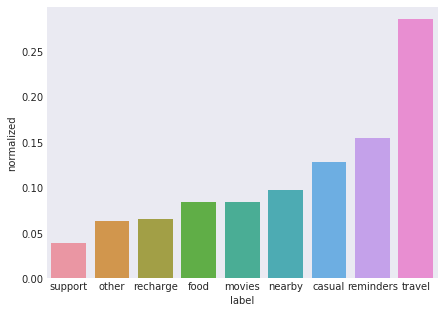

In [22]:
plot_yhist(y_train)     # Most frequent messages are related to travel, reminders, casual in Train dataset

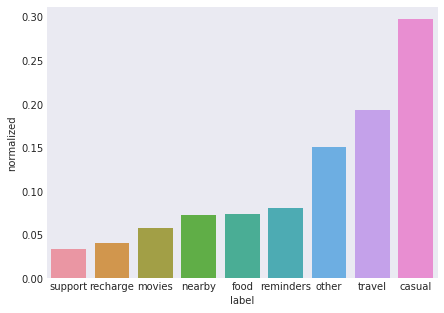

In [23]:
plot_yhist(y_test)    # Most frequent messages are related to casual, travel, others in Test dataset

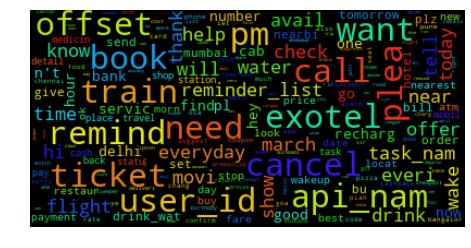

'create_word_cloud'  896.80 ms


In [65]:
create_word_cloud(X_train_1)

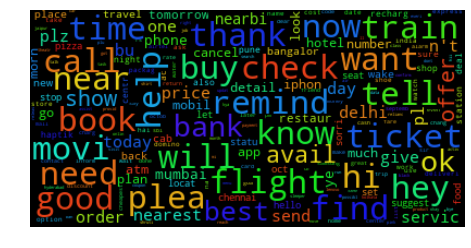

'create_word_cloud'  527.53 ms


In [66]:
create_word_cloud(X_test_1)

## Word Clouds for Labels

### wordcloud for Label Reminders

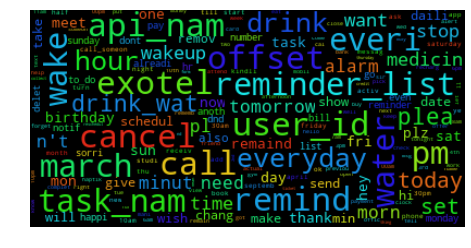

'create_word_cloud'  551.87 ms


In [68]:
create_word_cloud(X_train_1[train['reminders'] == 'T'])

### wordcloud for Label Travel

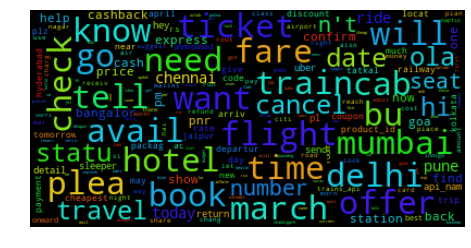

'create_word_cloud'  553.00 ms


In [69]:
create_word_cloud(X_train_1[train['travel'] == 'T'])

### wordcloud for Label Casual

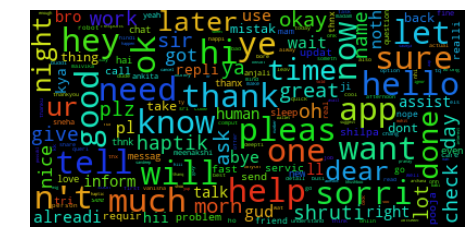

'create_word_cloud'  485.73 ms


In [70]:
create_word_cloud(X_train_1[train['casual'] == 'T'])

In [71]:
def freq_count(X):
    word_freq = {}
    for sentence in X:
        for word in sentence:                          
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    df = pd.DataFrame(word_freq.items(), columns = ['word','freq'])
    return df.sort_values(by = 'freq', ascending = 0 )
    
word_freq = freq_count(X_train_1)

In [72]:
word_freq[0:25]        # Most frequent words

,word,freq
1074,remind,4098
6768,can,3565
267,want,3262
13021,u,2170
12573,cancel,1951
20568,book,1818
14560,train,1708
19643,pleas,1674
9705,need,1644
15375,like,1641


In [73]:
word_freq.sort_values('freq')[0:25]      # All the words in 'word' column are least frequent

,word,freq
19284,chaat,1
6178,4541338361,1
6176,naa..thank,1
5941,jhushi,1
5940,shirts.,1
5938,hussain,1
5936,db,1
5719,anga,1
6179,nic,1
5718,temple..,1


#### The list total_curated contains our surated list of stop words which we'll remove from the vocabulary.

In [74]:
sw_curated = ['a9c0', 'f0af5ee2b89b', '676951', 'hi', '727893', '55616', 'task_nam',
              'user_id', '50', '16', 'exotel','ok', 'haptik', 'nearbi',
              'api_nam', 'offset', 'user_id', '00', 'pleas', 'can', 'pl',
              'drink_water', 'reminer_list', 'trains_api', 'product_id', 
              'I', 'j', 'se', 'sl', '10', 'hai', 'll', 'kya', 'rs', 'sorri',
              'know', '30', 'one', '10 00', 'bu', 'reminder_list',
              'plz', 'everi']

temporal = ['time', 'will', 'today', 'everyday', 'now', 'hour', 'tomorrow', 'day',\
'apr', 'april', 'fri', 'friday', 'june', 'later', 'may', 'min', 'minut',\
'mon', 'month', 'noon', 'nov', 'oct', 'octob', 'sat', 'sep', 'sept', 'sun',\
'sunday', 'thursday', 'tommorow', 'wed', 'wednesday', 'week', 'weekend', 'yesterday', 'hr']

misc = ['alreadi', 'also', 'around', 'ca', 'do', 'done', 'dont', 'iam', 'im', 'in',\
'it', 'just', 'let', 'much', 'name', 'oh', 'ok', 'okay', 'shall', 'sure', 'th',\
'that', 'to', 'wat', 'wil', 'yet', 'near', 'abt', 'didnt', 'fr', 'kk', 'll', 'nd', 'ohk']

pleasurantries = ['thank', 'hello', 'hi', 'hii', 'thanku', 'thnk', 'thnx', 'thx']

address = ['bro', 'dr', 'dude', 'mam', 'miss', 'mr', 'sir']

hindi = ['abhi', 'bhai', 'ho', 'hu', 'ji', 'ka', 'ke', 'ki', 'ko']

numeric = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', \
'ten', 'Eleven', 'Twelve', 'Thirteen', 'Fourteen', 'Fifteen', 'Sixteen', 'Seventeen', \
'Eighteen', 'Nineteen', 'Twenty', 'Twenty-one', 'Twenty-two', 'Twenty-three', \
'Twenty-four', 'Twenty-five', 'Twenty-six', 'Twenty-seven', 'Twenty-eight', \
'Twenty-nine', 'Thirty', 'Thirty-one']

ordinal = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eight', 'ninth', \
'tenth', 'eleventh', 'twelfth', 'thirteenth', 'fourteenth', 'fifteenth', 'sixteenth', \
'seventeenth', 'eighteenth', 'nineteenth', 'twentieth', 'twenty-first', 'twenty-second', \
'twenty-third', 'twenty-fourth', 'twenty-fifth', \
'twenty-sixth', 'twenty-seventh', 'twenty eighth', 'twenty-ninth', 'thirtieth', 'thirty-first']

total_curated = [sw_curated, temporal, misc, pleasurantries, address, hindi, numeric, ordinal]

In [75]:
X_train = preprocess(X_train, custom_stop = total_curated, stem = True)
X_test = preprocess(X_test, custom_stop = total_curated, stem = True)

In [34]:
X_train[0:5]

0                                [7am, everyday]
1                                 [chocol, cake]
2    [close, mortic, tenon, joint, door, diment]
3                        [train, eppo, kelambum]
4            [yesterday, cancel, flight, ticket]
Name: message, dtype: object

In [35]:
X_test[0:5]

0               [nearest, metro, station]
1    [pick, n, drop, servic, trough, cab]
2                       [want, buy, bick]
3                           [show, pizza]
4    [cheapest, packag, andaman, nicobar]
Name: message, dtype: object

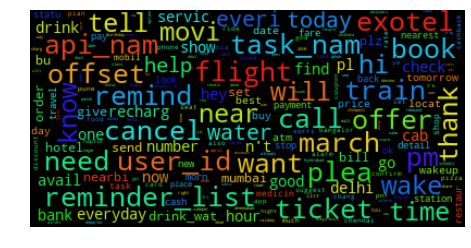

'create_word_cloud'  763.75 ms


In [36]:
create_word_cloud(X_train)

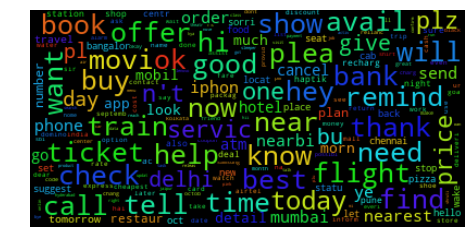

'create_word_cloud'  638.16 ms


In [37]:
create_word_cloud(X_test)

-----

# Classification Task

# Iterations:

## Iteration 1: Default Values

1. **model** = OneVsRestClassifier(LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial'))
2. **vectorizer** = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 94.81%
4. **Subset Accuracy** = 68.35%

In [38]:
from sklearn.linear_model import LogisticRegression
classify(X_train,y_train,X_test,y_test,
         model = OneVsRestClassifier(LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial')))

accuracy_label:  0.948122222222
accuracy_subset:  0.6835


classification report: 
              precision    recall  f1-score   support

          0       0.88      0.59      0.71       810
          1       0.82      0.64      0.72       450
          2       0.80      0.32      0.45       371
          3       0.92      0.81      0.86       893
          4       0.86      0.85      0.85      2138
          5       0.73      0.61      0.66       807
          6       0.88      0.57      0.69       637
          7       0.91      0.66      0.76      3282
          8       0.94      0.59      0.72      1668

avg / total       0.88      0.67      0.76     11056

'classify'  17433.62 ms


## Iteration 2: Default Values

1. **model** = OneVsRestClassifier(MultinomialNB(alpha = 0.4), 
2. **vectorizer** = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 93.74%
4. **Subset Accuracy** = 63.54%

In [39]:
classify(X_train,y_train,X_test,y_test,
         model = OneVsRestClassifier(MultinomialNB(alpha = 0.4)))

accuracy_label:  0.937422222222
accuracy_subset:  0.6354


classification report: 
              precision    recall  f1-score   support

          0       0.73      0.66      0.70       810
          1       0.63      0.73      0.68       450
          2       0.55      0.46      0.50       371
          3       0.90      0.80      0.85       893
          4       0.76      0.89      0.82      2138
          5       0.51      0.69      0.58       807
          6       0.71      0.64      0.67       637
          7       0.88      0.64      0.74      3282
          8       0.84      0.70      0.76      1668

avg / total       0.78      0.71      0.74     11056

'classify'  1768.14 ms


## Iteration 3: Default Values

1. **model** = RandomForestClassifier(n_estimators=200, n_jobs=-1)), 
2. **vectorizer** = CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)
3. **Label Accuracy** = 94.47%
4. **Subset Accuracy** = 72.34%

In [76]:
from sklearn.ensemble import RandomForestClassifier
classify(X_train,y_train,X_test,y_test,
         model = RandomForestClassifier(n_estimators=200, n_jobs=-1))

accuracy_label:  0.9447
accuracy_subset:  0.7234


classification report: 
              precision    recall  f1-score   support

          0       0.79      0.61      0.69       810
          1       0.74      0.67      0.70       450
          2       0.62      0.25      0.36       371
          3       0.87      0.84      0.85       893
          4       0.81      0.85      0.83      2138
          5       0.68      0.60      0.64       807
          6       0.73      0.62      0.67       637
          7       0.83      0.84      0.84      3282
          8       0.92      0.49      0.64      1668

avg / total       0.81      0.71      0.75     11056

'classify'  221756.87 ms


----------------------------------------**END**----------------------------------------